# Install required packages

In [33]:
%pip install transformers datasets
%pip install pandas
%pip install matplotlib
%pip install umap-learn
%pip install datashader bokeh holoviews colorcet scikit-image

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befor

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import transformers


# Load Data

In [35]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()


In [36]:
from datetime import datetime
import logging
from pandas._libs.tslibs.timestamps import Timestamp


def to_decade(date) -> str:
    if isinstance(date, Timestamp):
        return to_decade(date.year)
    elif isinstance(date, int):
        start = int(date / 10) * 10
        return f"{start} - {start+10}"
    elif isinstance(date, str):
        return to_decade(pd.to_datetime(date))
    else:
        raise RuntimeError(f"Invalid date: '{date}'")


def date_to_string(dt) -> str:
    if isinstance(dt, Timestamp):
        return str(dt.date())
    elif isinstance(dt, str):
        return dt
    else:
        raise RuntimeError(f"Invalid date: '{dt}'")


## ANP

In [37]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


In [38]:
from tqdm import tqdm


FILE_GLOB = "ANP_19[0-9][0-9].csv.gz"
ENCODING = "iso8859_15"

anp = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="content")
            for f in ANP_DIR.glob(FILE_GLOB)
        ),
        total=len(list(ANP_DIR.glob(FILE_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()
anp["decade"] = anp["year"].apply(to_decade)


anp


Reading: 100%|██████████| 48/48 [00:16<00:00,  2.90file/s]


,filename,content,date,year,month,day,issue,decade
0,anp_1952_01_01_10_ocr.xml,Red.: Datum: veldman 1-1-52 Tijd: 13 ttt^....,1952-01-01,1952,1,1,10,1950 - 1960
1,anp_1952_01_01_11_ocr.xml,Red. Datum: Tijd: Onderwerp: veltmeijer 1...,1952-01-01,1952,1,1,11,1950 - 1960
2,anp_1952_01_01_12_ocr.xml,/3* Red. Datum: Tijd: Onderwerp: veltmei...,1952-01-01,1952,1,1,12,1950 - 1960
3,anp_1952_01_01_13_ocr.xml,Red.: Datum: Tijd: Onderwerp: veltmeijer ...,1952-01-01,1952,1,1,13,1950 - 1960
4,anp_1952_01_01_14_ocr.xml,Red.: Datum: Tijd: Onderwerp: mallon 1-1-...,1952-01-01,1952,1,1,14,1950 - 1960
...,...,...,...,...,...,...,...,...
1474644,anp_1973_12_31_96_ocr.xml,Red.: Datum: Tijd: Onderwerp: kreek 31. 12. 7...,1973-12-31,1973,12,31,96,1970 - 1980
1474645,anp_1973_12_31_97_ocr.xml,Red.: Datum: Tijd: Onderwerp: kuy 31-12-...,1973-12-31,1973,12,31,97,1970 - 1980
1474646,anp_1973_12_31_98_ocr.xml,Red. Datum: Tijd: Onderwerp: kreek 31. 12...,1973-12-31,1973,12,31,98,1970 - 1980
1474647,anp_1973_12_31_99_ocr.xml,Red. Datum: Tijd: Onderwerp: zijl 31-12-...,1973-12-31,1973,12,31,99,1970 - 1980


Text(0, 0.5, 'Number of Documents')

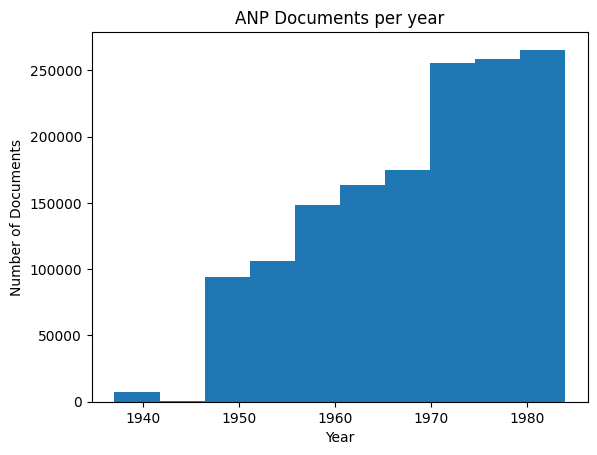

In [39]:
plt.hist(anp.year, label="Year")
plt.title("ANP Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

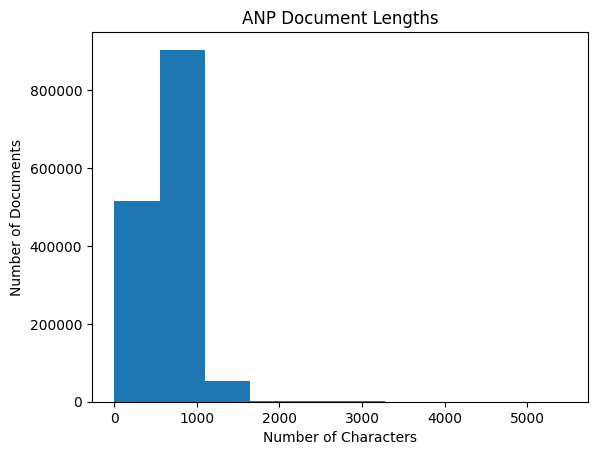

In [40]:
plt.hist(anp.content.str.len())
plt.title("ANP Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


## StatenGeneraal

In [41]:
SG_DIR = DATA_DIR / "StatenGeneraal"

assert SG_DIR.is_dir()

SG_GLOB = "StatenGeneraal_[12][890][0-9][0-9].csv.gz"

In [42]:
from tqdm import tqdm

ENCODING = "iso8859_15"


staten_generaal = pd.concat(
    tqdm(
        (
            pd.read_csv(
                f, compression="gzip", sep=";", encoding=ENCODING, parse_dates=["date"]
            ).dropna(subset="Content")
            for f in SG_DIR.glob(SG_GLOB)
        ),
        total=len(list(SG_DIR.glob(SG_GLOB))),
        unit="file",
        desc="Reading",
    ),
    ignore_index=True,
).convert_dtypes()

staten_generaal


Reading: 100%|██████████| 205/205 [01:31<00:00,  2.23file/s]


,Unnamed: 0,date,RecId,title,type,description,year,Content,ocr_link,pages,chamber,leg_period,speakers
0,144302,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Rijksbegroting voor het dienstjaar 1976. Defensie,BRIEF VAN DE MINISTER VAN DEFENSIE,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
1,144303,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Wijziging Liquidatiewet invaliditeitswetten,KONINKLIJKE BOODSCHAP,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
2,144304,1976-01-02,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,"Naturalisatie van Bakarbessy, Jacobus Hermanus...",KONINKLIJKE BOODSCHAP,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,1,StatenGeneraal,<NA>,<NA>
3,144305,1976-01-05,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Wijziging van de Kleuteronderwijswet (Stb. 197...,VERSLAG,1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
4,144306,1976-01-05,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Uitvoering van artikel 15 van de Comptabilitei...,NOTA NAAR AANLEIDING VAN HET VERSLAG,1976,Tweede Kamer der Staten-Generaal Zitting 1975-...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187141,108,1857-12-02 00:00:00,nl.proc.sgd.d.185718580000114,Handelingen Tweede Kamer 1857-1858 02 december...,Verbatim Proceedings,<NA>,1857,65ste vel. â 227 â Tweede Kamer.ZITTIN G V...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00697: mp, de heer: Kien; nl.m.00473: cha..."
187142,109,1857-12-07 00:00:00,nl.proc.sgd.d.185718580000115,Handelingen Tweede Kamer 1857-1858 07 december...,Verbatim Proceedings,<NA>,1857,G7stc vel. â 235 TV Tweede Kamer.27ste IIfT1...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00855: mp, De heer: baron van Lynden; nl...."
187143,110,1857-12-10 00:00:00,nl.proc.sgd.d.185718580000116,Handelingen Tweede Kamer 1857-1858 10 december...,Verbatim Proceedings,<NA>,1857,68ste vel. 237 â Tweede Kamer.Z1TITN G VAN D...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.02118: government, minister: Vrolik; nl.m..."
187144,111,1857-12-11 00:00:00,nl.proc.sgd.d.185718580000117,Handelingen Tweede Kamer 1857-1858 11 december...,Verbatim Proceedings,<NA>,1857,73ste vel. â 255 â Tweede Kamer.LXf. liuit...,<NA>,<NA>,TweedeKamer,1857-1858,"nl.m.00918: mp, De heer: Meijlink; nl.m.01557:..."


Text(0, 0.5, 'Number of Documents')

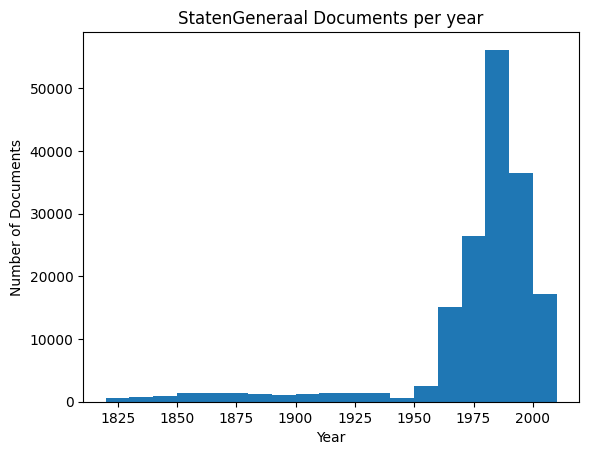

In [43]:
plt.hist(staten_generaal.year, label="Year", bins=range(1820, 2020, 10))
plt.title("StatenGeneraal Documents per year")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0.5, 0, 'Number of Characters')

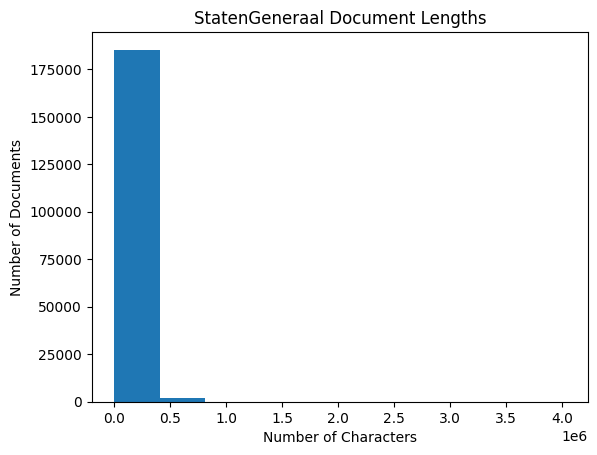

In [44]:
plt.hist(staten_generaal.Content.str.len())
plt.title("StatenGeneraal Document Lengths")
plt.ylabel("Number of Documents")
plt.xlabel("Number of Characters")


# Load Model

In [45]:
MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"  # NL MODEL TODO: is the model trained on lowercased data?

MODEL_MAX_LENGTH = 512


In [46]:
from transformers import AutoTokenizer, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline


tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, model_max_length=MODEL_MAX_LENGTH, truncation=True
)
# model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline(
    "feature-extraction",
    model=MODEL_NAME,
    tokenizer=tokenizer,
    max_length=MODEL_MAX_LENGTH,
    truncation=True,
)


Some weights of the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DTAI-KULeuven/robbertje-1-gb-non-shuffled and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this mode

# Find Contexts

In [47]:
TERM = "duurzaamheid"


In [48]:
term_token_ids = model.tokenizer(TERM)["input_ids"]
print(term_token_ids)

print(model.tokenizer.convert_ids_to_tokens(term_token_ids))


[0, 6395, 8262, 2]
['<s>', 'duur', 'zaamheid', '</s>']


## ANP

In [49]:
from src import Context

anp_contexts = []

anp_term_rows = anp.loc[anp.content.str.contains(TERM)]

for index, row in tqdm(anp_term_rows.iterrows(), total=len(anp_term_rows), unit="row"):
    anp_contexts.extend(
        Context.contexts(
            row.content,
            TERM,
            MODEL_MAX_LENGTH,
            model,
            {"date": row.date, "source": row.filename},
        )
    )

print(f"Rows containing '{TERM}' in ANP: {len(anp_term_rows)}")
print(f"Contexts found for '{TERM}' in ANP: {len(anp_contexts)}")


100%|██████████| 28/28 [00:00<00:00, 31.68row/s]

Rows containing 'duurzaamheid' in ANP: 28
Contexts found for 'duurzaamheid' in ANP: 29


In [50]:
anp_term_rows


,filename,content,date,year,month,day,issue,decade
28957,anp_1976_01_07_39_ocr.xml,Red.: cas Datum: 7-1-76 Tijd: Onderwerp: ...,1976-07-01,1976,1,7,39,1970 - 1980
83532,anp_1968_02_22_59_ocr.xml,Red.: Datu m: Tijd: Onderwerp: ..meij. e...,1968-02-22,1968,2,22,59,1960 - 1970
171251,anp_1950_09_03_61_ocr.xml,Cremers zondagweekoverzicht 3. 9*50 Het bese...,1950-03-09,1950,9,3,61,1950 - 1960
338005,anp_1983_02_10_117_ocr.xml,Red.: ser Datum: 10-2-83 Tijd: 11. 00 Ond...,1983-10-02,1983,2,10,117,1980 - 1990
338103,anp_1983_02_10_53_ocr.xml,Red. ser Datum: 10-2-83 Tijd: 11. 00 Onde...,1983-10-02,1983,2,10,53,1980 - 1990
363292,anp_1983_07_13_128_ocr.xml,Red.: Datum: Tijd: Onderwerp: spa 13 7 83 !<....,1983-07-13,1983,7,13,128,1980 - 1990
363338,anp_1983_07_13_3_ocr.xml,Red.: spa 13 ? 83 Tijd: Ond^Werp: o. e. ...,1983-07-13,1983,7,13,3,1980 - 1990
435255,anp_1970_12_19_65_ocr.xml,Red. Datum: Tijd: Onderwerp: ..r. ei. jn ...,1970-12-19,1970,12,19,65,1970 - 1980
566864,anp_1972_02_23_101_ocr.xml,Red. Datu m: Tijd: Onderwerp: jansen 23...,1972-02-23,1972,2,23,101,1970 - 1980
596591,anp_1972_10_09_90_ocr.xml,Red.: Datum: Tijd: Onderwerp: cas 9-10-7...,1972-09-10,1972,10,9,90,1970 - 1980


Text(0, 0.5, 'Number of Documents')

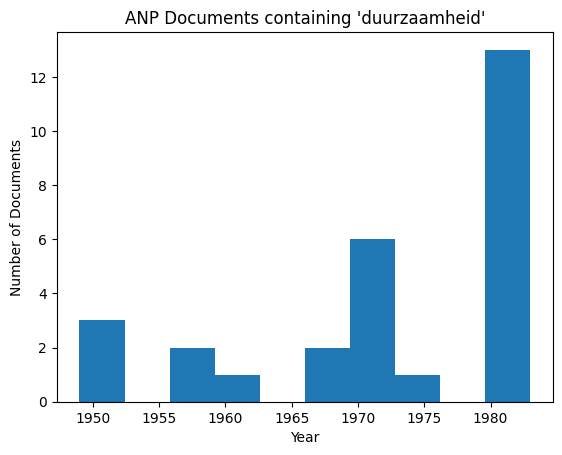

In [51]:
plt.hist(anp_term_rows.year)
plt.title(f"ANP Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0, 0.5, 'Number of Documents')

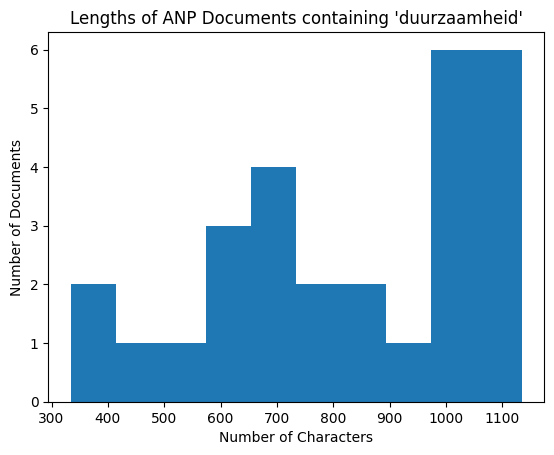

In [52]:
plt.hist(anp_term_rows.content.str.len())
plt.title(f"Lengths of ANP Documents containing '{TERM}'")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Documents")


## Staten Generaal

In [53]:
from tqdm import tqdm

sg_contexts = []
sg_term_rows = staten_generaal.loc[staten_generaal.Content.str.contains(TERM)]

for index, row in tqdm(sg_term_rows.iterrows(), total=len(sg_term_rows), unit="row"):
    sg_contexts.extend(
        Context.contexts(
            row.Content,
            TERM,
            MODEL_MAX_LENGTH,
            model,
            {"date": row.date, "source": row.RecId},
        )
    )
print(f"Rows containing '{TERM}' in Staten Generaal: {len(sg_term_rows)}")
print(f"Contexts found for '{TERM}' in Staten Generaal: {len(sg_contexts)}")


100%|██████████| 3249/3249 [00:05<00:00, 611.31row/s]

Rows containing 'duurzaamheid' in Staten Generaal: 3249
Contexts found for 'duurzaamheid' in Staten Generaal: 7740


In [54]:
sg_term_rows


,Unnamed: 0,date,RecId,title,type,description,year,Content,ocr_link,pages,chamber,leg_period,speakers
115,144430,1976-01-23,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Afsluiting Oosterschelde,BRIEF VAN DE MINISTER VAN VERKEER EN WATERSTAAT,1976,Tweede Kamer der Staten-Generaal Zitting 1975-...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",StatenGeneraal,<NA>,<NA>
163,144479,1976-01-30,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Vaststelling van Boek 6 van het nieuwe Burgerl...,MEMORIE VAN ANTWOORD,1976,Tweede Kamer der Staten-Generaal Zitting 1975-...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",StatenGeneraal,<NA>,<NA>
306,144651,1976-02-19,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Overeenkomst tussen het Koninkrijk der Nederla...,"Moskou, 15 juli 1975",1976,Eerste Kamer der Staten-Generaal 1 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
310,144655,1976-02-19,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Kamerstuk,Overeenkomst tussen het Koninkrijk der Nederla...,"Moskou, 15 juli 1975",1976,Tweede Kamer der Staten-Generaal 2 Zitting 197...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"1, 2, 3",StatenGeneraal,<NA>,<NA>
621,145041,1976-03-22,https://services.kb.nl/mdo/oai?verb=GetRecord&...,Handelingen,Handelingen Tweede Kamer OCV / UCV 1975-1976 2...,Handelingen Tweede Kamer OCV / UCV 1975-1976 2...,1976,Vaste Commissie voor Buitenlandse Zaken Maanda...,http://resolver.kb.nl/resolve?urn=sgd:19751976...,"681, 682, 683, 684, 685, 686, 687, 688, 689, 6...",StatenGeneraal,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186863,126,1957-03-28 00:00:00,nl.proc.sgd.d.195619570001147,Handelingen Tweede Kamer 1956-1957 28 maart 19...,Verbatim Proceedings,<NA>,1957,"Vragen, gesteld door mevrouw Heroma-Meilink 57...",<NA>,<NA>,TweedeKamer,1956-1957,"nl.m.00738: chair, voorzitter: Kortenhorst; nl..."
186887,150,1957-03-19 00:00:00,nl.proc.sgd.d.195619570001941,Handelingen Eerste Kamer 1956-1957 19 maart 19...,Verbatim Proceedings,<NA>,1957,Vaststelling begroting van het Zuiderzeefonds ...,<NA>,<NA>,EersteKamer,1956-1957,"nl.m.01117: mp, De heer: Roebroek; nl.m.01114:..."
186952,215,1957-10-02 00:00:00,nl.proc.sgd.d.195719580000239,Handelingen Tweede Kamer 1957-1958 02 oktober ...,Verbatim Proceedings,<NA>,1957,Ingekomen stukken 4de vergadering - 2 oktober ...,<NA>,<NA>,TweedeKamer,1957-1958,"nl.m.00738: chair, voorzitter: Kortenhorst; nl..."
187048,15,1857-03-02 00:00:00,nl.proc.sgd.d.185618570000152,Handelingen Tweede Kamer 1856-1857 02 maart 18...,Verbatim Proceedings,<NA>,1857,155ste vel. â 561 â Tweede Kamer.XLVIII. B...,<NA>,<NA>,TweedeKamer,1856-1857,"nl.m.00587: mp, De heer: baron van HoÃ«vell; n..."


Text(0, 0.5, 'Number of Documents')

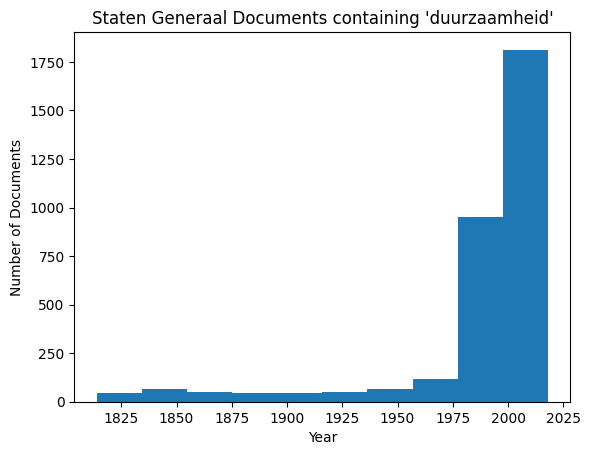

In [55]:
plt.hist(sg_term_rows.year)
plt.title(f"Staten Generaal Documents containing '{TERM}'")
plt.xlabel("Year")
plt.ylabel("Number of Documents")


Text(0, 0.5, 'Number of Documents')

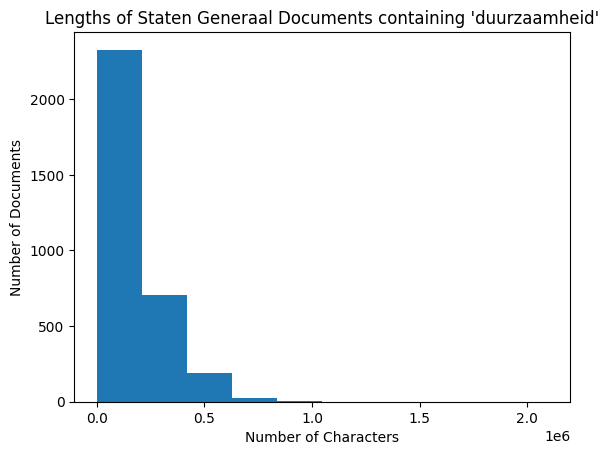

In [56]:
plt.hist(sg_term_rows.Content.str.len())
plt.title(f"Lengths of Staten Generaal Documents containing '{TERM}'")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Documents")


## Merge

In [57]:
from tqdm import tqdm
import random

BATCH_SIZE = 1000
RANDOM_SEED = 0

random.seed(RANDOM_SEED)

batch = random.sample(anp_contexts + sg_contexts, k=BATCH_SIZE)


# Compute Embeddings

In [58]:
token_embeddings = np.array(
    [context.token_embedding() for context in tqdm(batch, unit="context")]
)

assert token_embeddings.shape == (BATCH_SIZE, model.model.config.hidden_size)


 81%|████████  | 807/1000 [03:27<00:49,  3.88context/s]

# Plot

In [ ]:
import umap.plot

umap.plot.output_notebook()

title = f"UMAP Embeddings Projections for '{TERM}'"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loading BokehJS ...

In [ ]:
mapper = umap.UMAP().fit(token_embeddings)


## Static

Text(0.5, 1.0, "UMAP Embeddings Projections for 'duurzaamheid'")

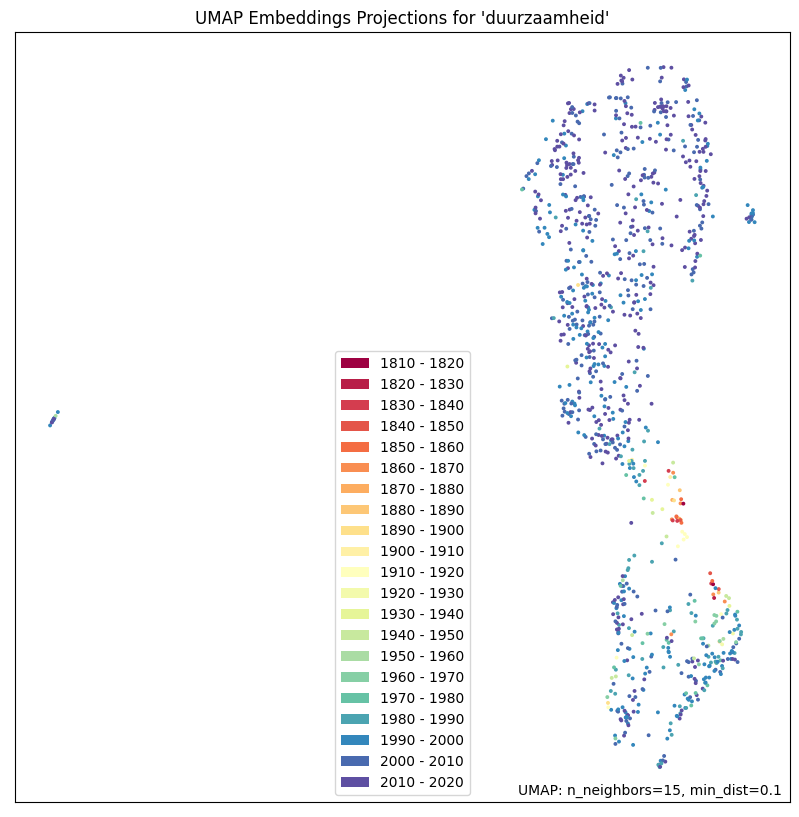

In [ ]:
labels = np.array([to_decade(context.metadata["date"]) for context in batch])
subplot = umap.plot.points(
    mapper,
    height=1000,
    width=1000,
    labels=labels
)
subplot.set_title(title)


## Interactive

In [ ]:
from bokeh.models import ColumnDataSource

metadatas = [
    {
        "x": embedding[0],
        "y": embedding[1],
        "date": date_to_string(context.metadata["date"]),
        "source": context.metadata["source"],
        "decade": label,
        "context": context.text,
    }
    for context, embedding, label in zip(batch, mapper.embedding_, labels)
]
metadatas
source = ColumnDataSource(data=pd.DataFrame(metadatas))
metadatas


[{'x': 7.381779,
  'y': 6.5595217,
  'date': '1992-08-26',
  'source': 'https://services.kb.nl/mdo/oai?verb=GetRecord&identifier=SGD:sgd:mpeg21:19911992:0003742&metadataPrefix=didl',
  'decade': '1990 - 2000',
  'context': '3. Op de langere termijn wordt een duurzaam gebruik van de Noordzee beoogd. Daartoe zal het AMOEBE-model, zoals ook al aangekondigd in het plan, voor de Noordzee nader worden uitgewerkt. De huidige versie is nog te beperkt als Â«definitieveÂ» maatlat voor duurzaamheid, maar biedt voldoende houvast binnen de planperiode. Bij de uitwerking zal rekening gehouden worden met het belang, dat andere (eco)systemen en hun gebruik stellen aan de Noordzee. Inmiddels wordt voor andere watersystemen ook gewerkt aan de concretiserin'},
 {'x': 10.561644,
  'y': 7.2454295,
  'date': '2015-12-14',
  'source': 'h-ek-20152016-12-4-n1',
  'decade': '2010 - 2020',
  'context': 'ntvangt mijn fractie van de staatssecretaris een schriftelijke beoordeling van deze maatregelen. Is hij bereid

In [ ]:
from bokeh.plotting import figure, show

p = figure(
    height=1000,
    width=1000,
    tooltips=[("source", "@source"), ("date", "@date"), ("context", "@context")],
)
p.title = title


In [ ]:
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
import bokeh.palettes

categories = anp.decade.unique()
palette = bokeh.palettes.Category20[len(categories)]

assert len(palette) >= len(
    categories
), f"Palette has only {len(palette)} categories, but {len(categories)} needed."

color_mapper = CategoricalColorMapper(
    factors=[str(c) for c in categories], palette=palette
)
color_mapper


CategoricalColorMapper(id='1039', ...)

In [ ]:
from bokeh.models.tickers import SingleIntervalTicker
from bokeh.plotting import figure, show


# TODO: group by decade to enable muting decades individually via legend
p.dot(
    x="x",
    y="y",
    legend_field="decade",
    source=source,
    size=20,
    color={"field": "decade", "transform": color_mapper},
)

p.legend.click_policy = "mute"


p.xaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)
p.yaxis.ticker = SingleIntervalTicker(desired_num_ticks=0)

show(p)
